In [1]:
# first try to models and forecast

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")


Loading BokehJS ...

In [3]:
uber = pd.read_csv('../uber_data.csv', parse_dates = ['pickup_dt'])
uber = uber.dropna()
uber = uber.set_index('pickup_dt')

In [4]:
#on va commencer par manhattan pour le moment
man_uber = uber[uber['borough'] == 'Manhattan']

In [5]:
man_uber = man_uber[man_uber.index.month == 1]
man_uber = man_uber.dropna()
man_uber.tail()

,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
pickup_dt,,,,,,,,,,,,
2015-01-31 19:00:00,Manhattan,5162,6.0,10.0,25.0,-2.0,1019.0,0.0,0.005,0.06,7.0,N
2015-01-31 20:00:00,Manhattan,5482,11.0,10.0,26.0,-3.0,1018.9,0.0,0.005,0.06,7.0,N
2015-01-31 21:00:00,Manhattan,4801,9.0,10.0,26.0,0.0,1019.1,0.0,0.000,0.06,7.0,N
2015-01-31 22:00:00,Manhattan,4939,17.0,10.0,25.0,0.0,1019.8,0.0,0.000,0.06,7.0,N
2015-01-31 23:00:00,Manhattan,5295,7.0,10.0,24.0,1.0,1020.3,0.0,0.000,0.06,7.0,N


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [8]:
time = man_uber.index.to_numpy()
#time

In [9]:
man_uber = man_uber['pickups']
man_uber = man_uber.to_numpy()
type(man_uber)

numpy.ndarray

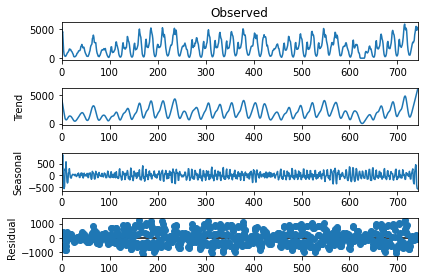

In [10]:
stl = STL(man_uber, period= 7)
result = stl.fit()
result.plot()
plt.show()

In [13]:
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys

In [14]:
y = pd.Series(data = man_uber)
y_train, y_test = temporal_train_test_split(y, test_size = 36)
print(y_train.shape[0])
print(y_test.shape[0])
print(type(y))

707
36
<class 'pandas.core.series.Series'>


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac11404850>)

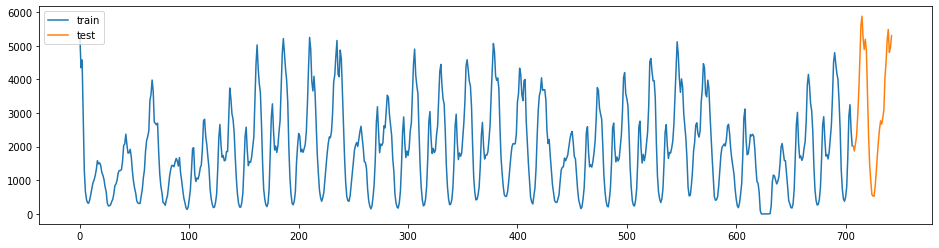

In [15]:
plot_ys(y_train, y_test, labels= ['train', 'test'])

In [18]:
#horizon de prediction
fh = np.arange(1,len(y_test)+1)

In [19]:
type(y_train)

pandas.core.series.Series

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac11b5d450>)

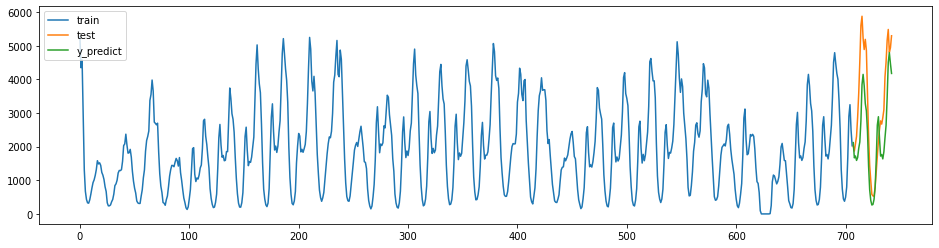

In [20]:
# avec sktime 

from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy='last',sp=50)

forecaster.fit(y_train)

y_predict_forecaster = forecaster.predict(fh)

plot_ys(y_train,y_test,y_predict_forecaster, labels = ['train', 'test','y_predict'])

In [29]:
score = smape_loss(y_predict_forecaster, y_test)
score

0.38912052506380596

In [28]:
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.compose import RecursiveRegressionForecaster
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# paramètre 'n_estimator' de scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [5,10,15,20,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = RecursiveRegressionForecaster(regressor, window_length=15)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

In [29]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(smape_loss(y_test, y_pred))
print(gscv.best_params_, gscv.best_forecaster_.regressor_.best_params_)

/Users/jerem/anaconda3/lib/python3.7/site-packages/sktime/forecasting/model_selection/_tune.py:135: FitFailedWarning: forecaster fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: No fits were performed. Was the CV iterator empty? Were there no candidates?

  FitFailedWarning)


ValueError: No fits were performed. Was the CV iterator empty? Were there no candidates?

In [37]:
man_uber_day = uber[uber['borough'] == 'Manhattan']
man_uber_day = man_uber_day[man_uber_day.index.month == 1]
man_uber_day = man_uber_day.dropna()
man_uber_day = man_uber_day[man_uber_day.index.day == 1]
man_uber_day.head(24)

,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
pickup_dt,,,,,,,,,,,,
2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2015-01-01 02:00:00,Manhattan,4345,3.0,10.0,30.0,6.0,1023.0,0.0,0.0,0.0,0.0,Y
2015-01-01 03:00:00,Manhattan,4577,5.0,10.0,30.0,8.0,1022.3,0.0,0.0,0.0,0.0,Y
2015-01-01 04:00:00,Manhattan,3003,5.0,10.0,29.0,9.0,1022.0,0.0,0.0,0.0,0.0,Y
2015-01-01 05:00:00,Manhattan,1313,5.0,10.0,28.0,9.0,1021.8,0.0,0.0,0.0,0.0,Y
2015-01-01 06:00:00,Manhattan,672,10.0,10.0,28.0,8.0,1020.7,0.0,0.0,0.0,0.0,Y
2015-01-01 07:00:00,Manhattan,431,9.0,10.0,28.0,10.0,1020.5,0.0,0.0,0.0,0.0,Y
2015-01-01 08:00:00,Manhattan,329,7.0,10.0,27.0,9.0,1020.5,0.0,0.0,0.0,0.0,Y
2015-01-01 09:00:00,Manhattan,319,3.0,10.0,27.0,7.0,1020.0,0.0,0.0,0.0,0.0,Y


In [38]:
man_uber_day = man_uber_day['pickups']
man_uber_day =man_uber_day.to_numpy()


In [39]:
y = pd.Series(data = man_uber_day)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac13963e10>)

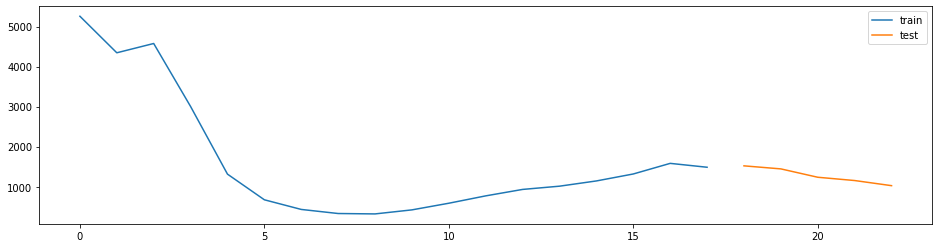

In [41]:
y_train, y_test = temporal_train_test_split(y, test_size= 5)
plot_ys(y_train, y_test, labels= ['train', 'test'])

In [42]:
fh = np.arange(1, len(y_test)+1)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac13a96690>)

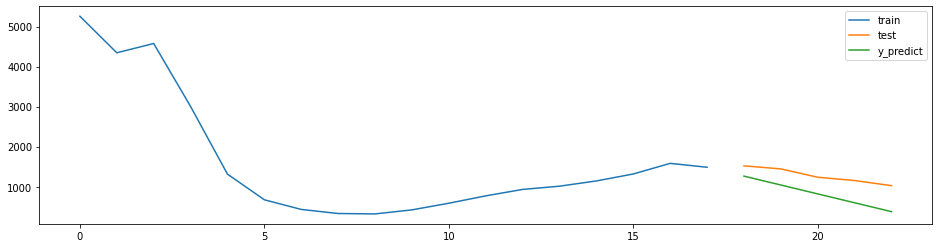

In [43]:


from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy='drift',sp=1)

forecaster.fit(y_train)

y_predict_forecaster = forecaster.predict(fh)

plot_ys(y_train,y_test,y_predict_forecaster, labels = ['train', 'test','y_predict'])

In [44]:
score = smape_loss(y_predict_forecaster, y_test)
score

0.4953539811278461

In [45]:
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.compose import RecursiveRegressionForecaster
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# paramètre 'n_estimator' de scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [5,10,15,20,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = RecursiveRegressionForecaster(regressor, window_length=15)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

/Users/jerem/anaconda3/lib/python3.7/site-packages/sktime/forecasting/model_selection/_tune.py:135: FitFailedWarning: forecaster fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.

  FitFailedWarning)
/Users/jerem/anaconda3/lib/python3.7/site-packages/sktime/forecasting/model_selection/_tune.py:135: FitFailedWarning: forecaster fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The window length and forecasting horizon are incompatible with the length of `y`

  FitFailedWarning)


0.25654991415807016
{'window_length': 5} {'n_estimators': 100}


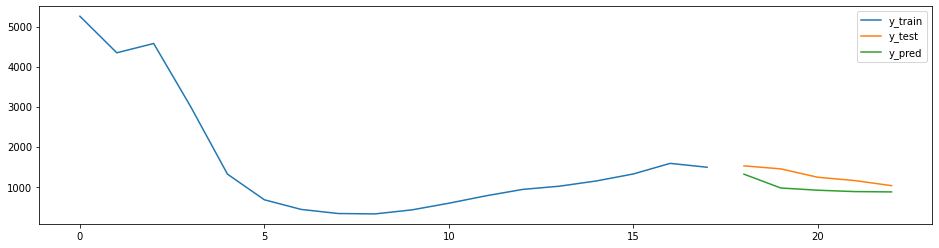

In [46]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(smape_loss(y_test, y_pred))
print(gscv.best_params_, gscv.best_forecaster_.regressor_.best_params_)

In [47]:
man_uber = uber[uber['borough'] == 'Manhattan']
#man_uber = man_uber[man_uber.index.month == 1]
man_uber = man_uber.dropna()
man_uber.tail()

,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
pickup_dt,,,,,,,,,,,,
2015-06-30 19:00:00,Manhattan,4585,5.0,10.0,80.0,58.0,1012.5,0.0,0.0,0.0,0.0,N
2015-06-30 20:00:00,Manhattan,4210,8.0,10.0,80.0,58.0,1012.4,0.0,0.0,0.0,0.0,N
2015-06-30 21:00:00,Manhattan,4313,7.0,10.0,76.0,61.0,1012.4,0.0,0.0,0.0,0.0,N
2015-06-30 22:00:00,Manhattan,4452,5.0,10.0,76.0,64.0,1011.9,0.0,0.0,0.0,0.0,N
2015-06-30 23:00:00,Manhattan,3828,7.0,10.0,75.0,65.0,1011.8,0.0,0.0,0.0,0.0,N


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac13d6e850>)

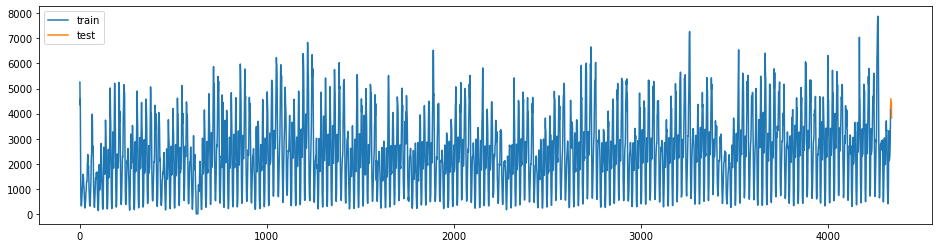

In [51]:
man_uber = man_uber['pickups']
man_uber =man_uber.to_numpy()
y = pd.Series(data = man_uber)
y_train, y_test = temporal_train_test_split(y, test_size= 5)
plot_ys(y_train, y_test, labels= ['train', 'test'])

In [52]:
# paramètre 'n_estimator' de scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [5,10,15,20,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = RecursiveRegressionForecaster(regressor, window_length=15)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

0.038089747129313
{'window_length': 25} {'n_estimators': 300}


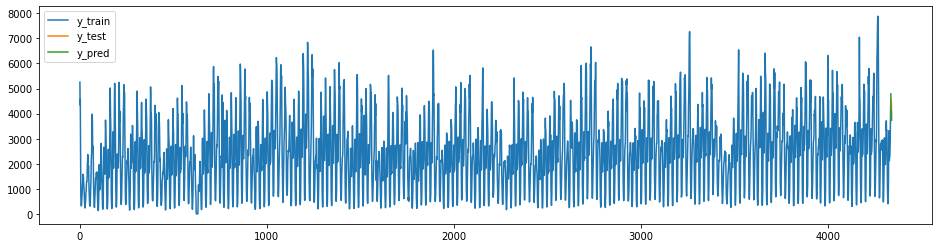

In [53]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(smape_loss(y_test, y_pred))
print(gscv.best_params_, gscv.best_forecaster_.regressor_.best_params_)

In [60]:
y_pred = gscv.predict(np.arange(1,167+1))
#plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

pd.concat([y_train, y_test,y_pred], axis=1).plot(
    colormap=('blue', 'orange', 'gray', 'gray'), legend='bottom_left');